In [43]:
# importing required packages

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

In [44]:
# getting data in a pandas dataframe

dataframe = pd.read_excel('training_set_rel.xlsx', encoding = 'latin-1')

In [45]:
# getting relevant columns

data = dataframe[['essay_set','essay','domain1_score']].copy()

#print(data)

In [46]:
# Tokenize a sentence into words

def sentence_to_wordlist(raw_sentence):
    
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    
    return tokens

In [47]:
# tokenizing an essay into a list of word lists

def tokenize(essay):
    stripped_essay = essay.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    
    return tokenized_sentences

In [48]:
# calculating average word length in an essay

def avg_word_len(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return sum(len(word) for word in words) / len(words)

In [49]:
# calculating number of words in an essay

def word_count(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return len(words)

In [50]:
# calculating number of characters in an essay

def char_count(essay):
    
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    
    return len(clean_essay)

In [51]:
# calculating number of sentences in an essay

def sent_count(essay):
    
    sentences = nltk.sent_tokenize(essay)
    
    return len(sentences)

In [52]:
# calculating number of lemmas per essay

def count_lemmas(essay):
    
    tokenized_sentences = tokenize(essay)      
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return lemma_count

In [53]:
# checking number of misspelled words

def count_spell_error(essay):
    
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
    
    #big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg 
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()
    
    words_ = re.findall('[a-z]+', data.lower())
    
    word_dict = collections.defaultdict(lambda: 0)
                       
    for word in words_:
        word_dict[word] += 1
                       
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
                        
    mispell_count = 0
    
    words = clean_essay.split()
                        
    for word in words:
        if not word in word_dict:
            mispell_count += 1
    
    return mispell_count

In [54]:
# calculating number of nouns, adjectives, verbs and adverbs in an essay

def count_pos(essay):
    
    tokenized_sentences = tokenize(essay)
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            
    return noun_count, adj_count, verb_count, adv_count
    

In [55]:
# getiing Bag of Words (BOW) counts

def get_count_vectors(essays):
    
    vectorizer = CountVectorizer(max_features = 10000, ngram_range=(1, 3), stop_words='english')
    
    count_vectors = vectorizer.fit_transform(essays)
    
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, count_vectors

In [56]:
# splitting data into train data and test data (70/30)

feature_names_cv, count_vectors = get_count_vectors(data[data['essay_set'] == 1]['essay'])

X_cv = count_vectors.toarray()

y_cv = data[data['essay_set'] == 1]['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [57]:
# Training a Linear Regression model using only Bag of Words (BOW)

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n',  linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

Coefficients: 
 [-0.00579514  0.0100035   0.00201645 ... -0.00325098 -0.0032496
  0.00176876]
Mean squared error: 4.21
Variance score: 0.51
Cohen's kappa score: 0.05


In [58]:
# extracting essay features

def extract_features(data):
    
    features = data.copy()
    
    features['char_count'] = features['essay'].apply(char_count)
    
    features['word_count'] = features['essay'].apply(word_count)
    
    features['sent_count'] = features['essay'].apply(sent_count)
    
    features['avg_word_len'] = features['essay'].apply(avg_word_len)
    
    features['lemma_count'] = features['essay'].apply(count_lemmas)
    
    features['spell_err_count'] = features['essay'].apply(count_spell_error)
    
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(*features['essay'].map(count_pos))
    
    return features

In [59]:
# extracting features from essay set 1

features_set1 = extract_features(data[data['essay_set'] == 1])

print(features_set1)

    essay_set                                              essay  \
0           1  Dear local newspaper, I think effects sharma  ...   
1           1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2           1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3           1  Dear Local Newspaper, @CAPS1 I have found that...   
4           1  Dear @LOCATION1, I know having computers has a...   
5           1  Dear @LOCATION1, I think that computers have a...   
6           1  Did you know that more and more people these d...   
7           1  @PERCENT1 of people agree that computers make ...   
8           1  Dear reader, @ORGANIZATION1 has had a dramatic...   
9           1  In the @LOCATION1 we have the technology of a ...   
10          1  Dear @LOCATION1, @CAPS1 people acknowledge the...   
11          1  Dear @CAPS1 @CAPS2 I feel that computers do ta...   
12          1  Dear local newspaper I raed ur argument on the...   
13          1  My three detaileds for this news 

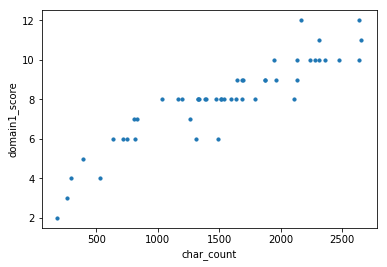

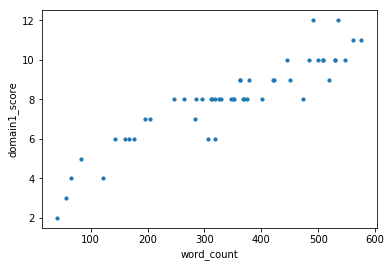

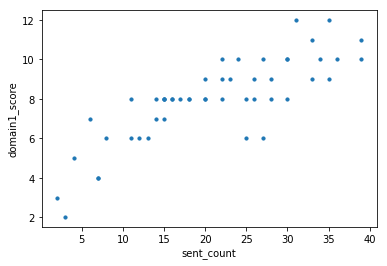

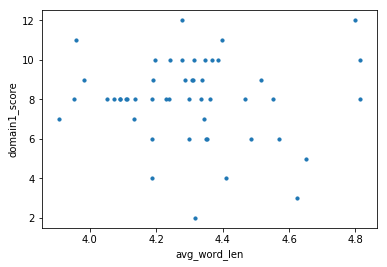

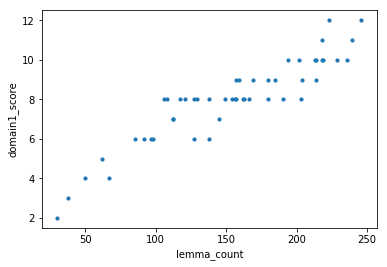

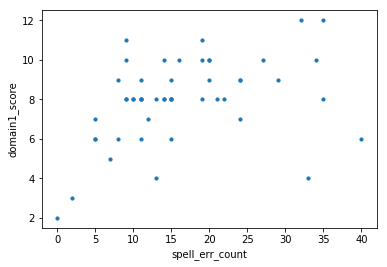

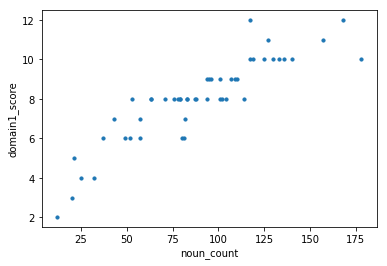

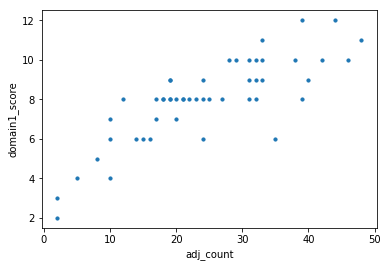

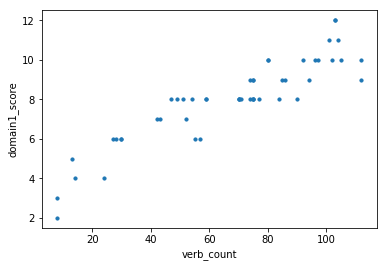

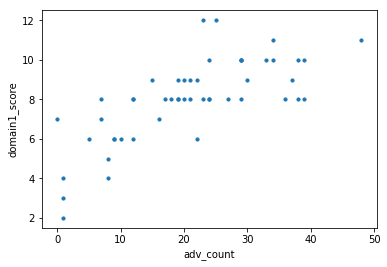

In [60]:
# Exploratory Data Analysis (EDA) on the data

%matplotlib inline
features_set1.plot.scatter(x = 'char_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'word_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'sent_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'avg_word_len', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'lemma_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'spell_err_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'noun_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adj_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'verb_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adv_count', y = 'domain1_score', s=10)



In [61]:
# splitting data (BOW + other features) into train data and test data (70/30)
    
X = np.concatenate((features_set1.iloc[:, 3:].as_matrix(), X_cv), axis = 1)

y = features_set1['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [62]:
# Training a Linear Regression model using all the features (BOW + other features)

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

Coefficients: 
 [-0.00301453  0.01464316 -0.02354914 ... -0.0005042  -0.0005042
 -0.00026469]
Mean squared error: 0.99
Variance score: 0.83
Cohen's kappa score: 0.20


In [63]:
# splitting data (only 10 numerical/POS/orthographic features) into train data and test data (70/30)
    
X = features_set1.iloc[:, 3:].as_matrix()

y = features_set1['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [64]:
# Training a Linear Regression model using only 10 numerical/POS/orthographic features

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

Coefficients: 
 [ 2.23462393e-04  1.80719620e-02 -7.45898063e-03 -7.08040049e-01
  3.75788220e-02  2.01857364e-02 -2.51795217e-02 -2.09401042e-02
 -2.95273068e-02 -8.07984656e-02]
Mean squared error: 1.18
Variance score: 0.49
Cohen's kappa score: 0.21


In [65]:
print(features_set1.iloc[:, 3:].as_matrix())

[[1.54300000e+03 3.51000000e+02 1.60000000e+01 4.23931624e+00
  1.63000000e+02 1.00000000e+01 8.30000000e+01 1.80000000e+01
  7.50000000e+01 2.40000000e+01]
 [1.87000000e+03 4.23000000e+02 2.00000000e+01 4.31205674e+00
  1.85000000e+02 2.40000000e+01 1.07000000e+02 1.90000000e+01
  8.50000000e+01 1.90000000e+01]
 [1.26300000e+03 2.83000000e+02 1.40000000e+01 4.34275618e+00
  1.45000000e+02 5.00000000e+00 8.20000000e+01 2.00000000e+01
  5.20000000e+01 1.60000000e+01]
 [2.64200000e+03 5.30000000e+02 2.70000000e+01 4.81320755e+00
  2.36000000e+02 3.40000000e+01 1.78000000e+02 4.20000000e+01
  9.70000000e+01 2.90000000e+01]
 [2.10500000e+03 4.73000000e+02 3.00000000e+01 4.33403805e+00
  1.90000000e+02 1.90000000e+01 1.14000000e+02 3.20000000e+01
  9.00000000e+01 3.60000000e+01]
 [1.03100000e+03 2.47000000e+02 1.50000000e+01 4.05263158e+00
  1.27000000e+02 1.50000000e+01 5.30000000e+01 1.20000000e+01
  4.90000000e+01 1.70000000e+01]
 [2.31000000e+03 5.08000000e+02 3.00000000e+01 4.38582677e

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
